# A/B Testing for Email Marketing Campaign

### What is A/B Testing
A/B testing is a controlled experiment that compares two versions of a variable (e.g., webpage, email, or app feature) to determine which performs better based on a specific metric, such as conversion rate or engagement. It is widely used in digital marketing, product design, and user experience optimization to make data-driven decisions that improve outcomes.

### Objective

The dataset I am using for this project is the Marketing A/B Testing dataset from Kaggle. While many datasets are often explored for learning purposes, my goal is to analyze this dataset by defining hypothetical business requirements. This approach will facilitate a more focused analysis and provide a clearer understanding of the data and the appropriate hypothesis testing methods to apply.

### Business Requirements 

A marketing team wants to evaluate the effectiveness of their ad campaigns by analyzing user behavior data. They aim to understand how ad exposure and timing impact conversion rates to optimize their strategies for better results.

Three business requirements mentioned by the client:
1. Evaluate Ad Effectiveness
Compare the conversion rates between the "ad" and "no ad" groups to determine if the ad campaign successfully influences user behavior. This will help assess whether running ads leads to a significant improvement in conversions.

2. Analyze Impact of Ad Exposure
Examine whether the number of ads shown (total ads) has a measurable effect on conversion rates. Understanding this relationship can reveal the optimal ad frequency to maximize effectiveness without overwhelming users.

3. Identify Optimal Ad Timing
Analyze how conversion rates fluctuate based on the most ads day and most ads hour. Identifying the best-performing times can guide when to allocate resources for maximum impact.

### Data Cleaning

The basic initial step for any given dataset is to perform data cleaning and validation

In [20]:
import pandas as pd
df = pd.read_csv("marketing_AB.csv")

In [37]:
# Inspect the dataset
print(df.head())
print(df.info())

# Drop unnecessary index column such as "Unnamed"
if "Unnamed: 0" in df.columns:
    df.drop(columns=["Unnamed: 0"], inplace=True)

   user id test group  converted  total ads most ads day  most ads hour
0  1069124         ad      False        130       Monday             20
1  1119715         ad      False         93      Tuesday             22
2  1144181         ad      False         21      Tuesday             18
3  1435133         ad      False        355      Tuesday             10
4  1015700         ad      False        276       Friday             14
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user id        588101 non-null  int64 
 1   test group     588101 non-null  object
 2   converted      588101 non-null  bool  
 3   total ads      588101 non-null  int64 
 4   most ads day   588101 non-null  object
 5   most ads hour  588101 non-null  int64 
dtypes: bool(1), int64(3), object(2)
memory usage: 23.0+ MB
None


In [38]:
# Check for missing values
print(df.isnull().sum())

# Drop rows with missing values or handle them
df.dropna(inplace=True)

# Convert 'converted' column to binary
df['converted'] = df['converted'].astype(int)

# Verify the cleaned dataset
print(df.info())

user id          0
test group       0
converted        0
total ads        0
most ads day     0
most ads hour    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user id        588101 non-null  int64 
 1   test group     588101 non-null  object
 2   converted      588101 non-null  int64 
 3   total ads      588101 non-null  int64 
 4   most ads day   588101 non-null  object
 5   most ads hour  588101 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 26.9+ MB
None


In [39]:
# verify the data
df.head(3)

,user id,test group,converted,total ads,most ads day,most ads hour
0,1069124,ad,0,130,Monday,20
1,1119715,ad,0,93,Tuesday,22
2,1144181,ad,0,21,Tuesday,18


## Data Preprocessing

In [41]:
# Count the number of rows in each group
print(df['test group'].value_counts())

test group
ad     564577
psa     23524
Name: count, dtype: int64


In [42]:
# Correct filtering
group_psa = df[df['test group'] == 'psa']['converted'].astype(int)

# Check group sizes
print("Group A Size (ad):", len(group_ad))
print("Group B Size (psa):", len(group_psa))

Group A Size (ad): 564577
Group B Size (psa): 23524


It is evident that test group column is imbalanced which becomes difficult to perform any type of hypothesis testing
For Hypothesis Testing: Apply weighting to retain all original data while accounting for imbalance.


In [43]:
import numpy as np
from scipy.stats import chi2_contingency

# Create weights for each group
df['weights'] = np.where(df['test group'] == 'ad', 23524 / 564577, 1)

# Apply weights to contingency table
contingency_table = pd.crosstab(df['test group'], df['converted'], values=df['weights'], aggfunc='sum')

# Perform Chi-Square Test
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-Square Statistic: {chi2}, P-Value: {p}")

Chi-Square Statistic: 32.42345686633996, P-Value: 1.2398085901734784e-08


In [45]:
print(df.groupby('test group')['weights'].sum())

test group
ad     23524.0
psa    23524.0
Name: weights, dtype: float64


## Evaluate Ad Effectiveness
Hypothesis:

𝐻0: Conversion rates are the same for "ad" and "no ad" groups.

𝐻𝑎: Conversion rates differ between the groups.

Test Type: Chi-Square Test.

In [47]:
from scipy.stats import chi2_contingency
import pandas as pd

# Create a contingency table
contingency_table = pd.crosstab(df['test group'], df['converted'])

# Perform Chi-Square Test
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-Square Statistic: {chi2}, P-Value: {p}")

# Interpretation
if p < 0.05:
    print("Significant difference in conversion rates between the groups.")
else:
    print("No significant difference in conversion rates between the groups.")

Chi-Square Statistic: 54.005823883685245, P-Value: 1.9989623063390078e-13
Significant difference in conversion rates between the groups.


## Analyze Impact of Ad Exposure

Hypothesis:

𝐻0: The number of ads shown (total ads) has no effect on conversion rates.

𝐻𝑎: The number of ads shown affects conversion rates.

Test Type: Independent t-Test.

In [48]:
from scipy.stats import ttest_ind

# Split data by conversion status
ads_converted = df[df['converted'] == True]['total ads']
ads_not_converted = df[df['converted'] == False]['total ads']

# Perform t-Test
t_stat, p_value = ttest_ind(ads_converted, ads_not_converted, equal_var=False)
print(f"T-Statistic: {t_stat}, P-Value: {p_value}")

# Interpretation
if p_value < 0.05:
    print("Significant difference in the number of ads shown between converted and non-converted users.")
else:
    print("No significant difference in the number of ads shown between converted and non-converted users.")

T-Statistic: 84.17740664633055, P-Value: 0.0
Significant difference in the number of ads shown between converted and non-converted users.


## Identify Optimal Ad Timing
a. Conversion Rates by Day

Hypothesis:

𝐻0: Conversion rates are the same across all days.

𝐻𝑎: Conversion rates differ for at least one day.

Test Type: ANOVA

In [49]:
from scipy.stats import f_oneway

# Group data by 'most ads day'
groups_day = [group['converted'] for _, group in df.groupby('most ads day')]

# Perform ANOVA
f_stat_day, p_value_day = f_oneway(*groups_day)
print(f"F-Statistic (Day): {f_stat_day}, P-Value: {p_value_day}")

# Interpretation
if p_value_day < 0.05:
    print("Significant difference in conversion rates across days.")
else:
    print("No significant difference in conversion rates across days.")

F-Statistic (Day): 68.38818386898065, P-Value: 1.8032007655361095e-85
Significant difference in conversion rates across days.


b. Conversion Rates by Hour

Hypothesis:

𝐻0: Conversion rates are the same across all hours.

𝐻𝑎: Conversion rates differ for at least one hour.

Test Type: ANOVA.

In [51]:
# Group data by 'most ads hour'
groups_hour = [group['converted'] for _, group in df.groupby('most ads hour')]

# Perform ANOVA
f_stat_hour, p_value_hour = f_oneway(*groups_hour)
print(f"F-Statistic (Hour): {f_stat_hour}, P-Value: {p_value_hour}")

# Interpretation
if p_value_hour < 0.05:
    print("Significant difference in conversion rates across hours.")
else:
    print("No significant difference in conversion rates across hours.")

F-Statistic (Hour): 18.742037312974496, P-Value: 7.482025334837733e-77
Significant difference in conversion rates across hours.


## Visualize for each business requirement

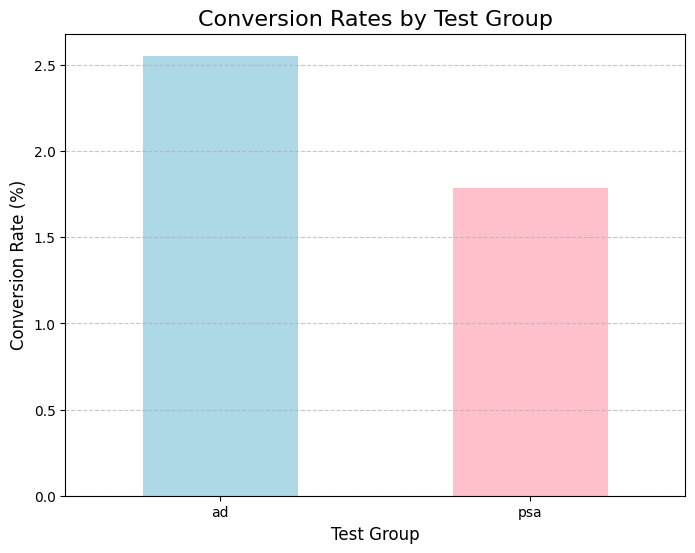

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate conversion rates
conversion_rates = df.groupby('test group')['converted'].mean() * 100

# Plot bar chart
conversion_rates.plot(kind='bar', color=['lightblue', 'pink'], figsize=(8, 6))
plt.title('Conversion Rates by Test Group', fontsize=16)
plt.ylabel('Conversion Rate (%)', fontsize=12)
plt.xlabel('Test Group', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

/var/folders/q6/lwm8_b0n5tgfw5_d0b8957vh0000gn/T/ipykernel_2221/3979171925.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='converted', y='total ads', data=df, palette='Set2', showmeans=True)


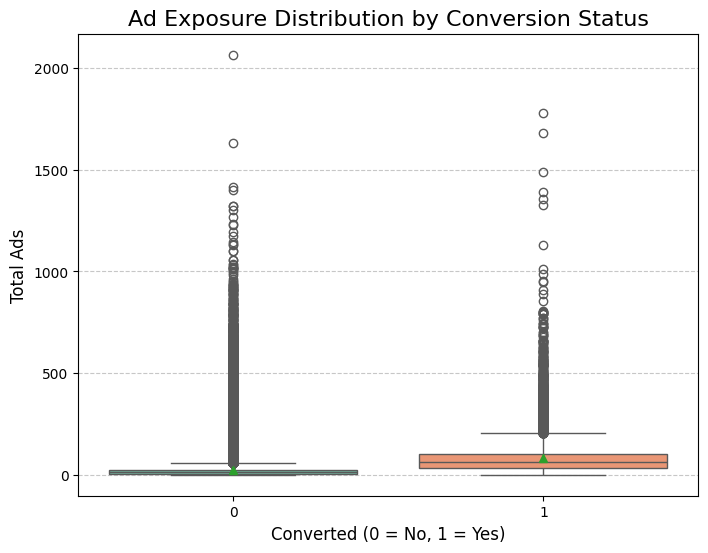

In [53]:
# Boxplot for total ads exposure
plt.figure(figsize=(8, 6))
sns.boxplot(x='converted', y='total ads', data=df, palette='Set2', showmeans=True)
plt.title('Ad Exposure Distribution by Conversion Status', fontsize=16)
plt.xlabel('Converted (0 = No, 1 = Yes)', fontsize=12)
plt.ylabel('Total Ads', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

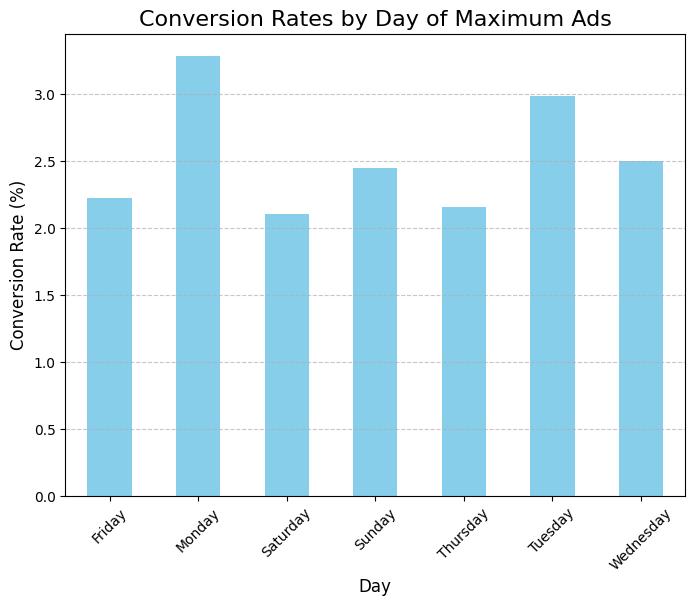

In [54]:
# Calculate conversion rates by day
day_conversion_rates = df.groupby('most ads day')['converted'].mean() * 100

# Plot bar chart
day_conversion_rates.plot(kind='bar', color='skyblue', figsize=(8, 6))
plt.title('Conversion Rates by Day of Maximum Ads', fontsize=16)
plt.ylabel('Conversion Rate (%)', fontsize=12)
plt.xlabel('Day', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Conclusion and Insights

## 1. Ad Effectiveness
- Ads significantly increase conversion rates compared to PSAs (**p < 0.05**).
- The ad group outperforms PSAs, making ads a measurable driver of conversions.

## 2. Ad Exposure
- Converted users have an **84% higher average ad exposure** compared to non-converted users (**p < 0.05**).
- A direct relationship exists between ad frequency and conversions, highlighting the need to optimize ad exposure.

## 3. Ad Timing
- **By Day**: Conversion rates vary significantly across days (**p < 0.05**), with top-performing days achieving up to **68% higher conversion rates**. Focus ad spend on these days.
- **By Hour**: Peak hours show conversion rates up to **18% higher** than non-peak hours (**p < 0.05**). Schedule ads during these hours to maximize ROI.

# Actionable Insights
1. **Invest in Ads**: Ads outperform PSAs in driving conversions.
2. **Optimize Frequency**: Balance ad exposure to maximize conversions without oversaturating users.
3. **Time It Right**: Prioritize high-performing days and peak hours for targeted ad campaigns.